In [1]:
import pandas as pd

In [22]:
orders = pd.read_csv('Online_Retail.csv', parse_dates=['InvoiceDate'])

In [23]:
orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Pre-processing

We require only
* CustomerID
* InvoiceNo
* InvoiceDate
* Quantity
* UnitPrice

In [24]:
required_columns = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice']
data = orders[required_columns]

In [25]:
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])
data.head()

C:\Users\Ashwin\AppData\Local\Temp/ipykernel_2156/1705705588.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,TotalSales
0,17850.0,536365,2010-12-01 08:26:00,6,2.55,15.30
1,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
2,17850.0,536365,2010-12-01 08:26:00,8,2.75,22.00
3,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
4,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34


We need not consider negative values that represent item returns

In [26]:
data = data[data.TotalSales > 0]

Check for null values

In [27]:
data.isnull().mean()

CustomerID     0.249423
InvoiceNo      0.000000
InvoiceDate    0.000000
Quantity       0.000000
UnitPrice      0.000000
TotalSales     0.000000
dtype: float64

In [28]:
data = data.dropna()

In [29]:
data.isnull().mean()

CustomerID     0.0
InvoiceNo      0.0
InvoiceDate    0.0
Quantity       0.0
UnitPrice      0.0
TotalSales     0.0
dtype: float64

In [30]:
data.iloc[0].InvoiceDate

Timestamp('2010-12-01 08:26:00')

## Aggregate Model

In [34]:
customer = data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (x.max() - x.min()).days, 
                                           'InvoiceNo': lambda x: len(x),
                                           'TotalSales': lambda x: sum(x)})

customer = customer.reset_index()
customer.columns = ['CustomerID', 'Age', 'Frequency', 'TotalSales']
customer.head()

,CustomerID,Age,Frequency,TotalSales
0,12346.0,0,1,77183.60
1,12347.0,365,182,4310.00
2,12348.0,282,31,1797.24
3,12349.0,0,73,1757.55
4,12350.0,0,17,334.40


In [43]:
avg_sales = customer.TotalSales.mean()
print("Average Sales:", round(avg_sales, 2))
########
purchase_freq = customer.Frequency.mean()
print("Purchase Frequency: ", round(purchase_freq, 2))
########
churn = customer[customer['Frequency']<=1].shape[0]/customer.shape[0]
print("Churn: ", round(churn, 2))
########
profit_margin = 0.05
print("Profit Margin: ", round(profit_margin, 2))

Average Sales: 2054.27
Purchase Frequency:  91.72
Churn:  0.02
Profit Margin:  0.05


In [48]:
def get_clv(customer, profit_margin=0.05):
    avg_sales = customer.TotalSales.mean()
    purchase_freq = customer.Frequency.mean()
    churn = customer[customer['Frequency']<=1].shape[0]/customer.shape[0]
    CLV = round(((avg_sales * purchase_freq/churn)) * profit_margin, 2)
    return CLV

In [40]:
CLV = round(((avg_sales * purchase_freq/churn)) * profit_margin, 2)
print(f"The Customer Lifetime Value (CLV) for each customer is: ${CLV}")

The Customer Lifetime Value (CLV) for each customer is: $575605.46


This aggregate model is not accurate since we cannot expect each customer to spend 575K dollars.

The data is skewed towards a few higher spending customers:

In [44]:
customer.TotalSales.describe()

count      4338.000000
mean       2054.266460
std        8989.230441
min           3.750000
25%         307.415000
50%         674.485000
75%        1661.740000
max      280206.020000
Name: TotalSales, dtype: float64

## Cohort by month

In [47]:
customer = data.groupby('CustomerID').agg({'InvoiceDate':lambda x: x.min().month,
                                           'InvoiceNo': lambda x: len(x),
                                           'TotalSales': lambda x: sum(x)})
customer = customer.reset_index()
customer.columns = ['CustomerID', 'Month', 'Frequency', 'TotalSales']
customer.head()

,CustomerID,Month,Frequency,TotalSales
0,12346.0,1,1,77183.60
1,12347.0,12,182,4310.00
2,12348.0,12,31,1797.24
3,12349.0,11,73,1757.55
4,12350.0,2,17,334.40


In [49]:
months = ['Jan', 'Feb', 'March', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_clv = []
for i in range(1, 13):
    customer_m = customer[customer.Month == i]
    clv_m = get_clv(customer_m)
    monthly_clv.append(clv_m)
monthly_clv = pd.DataFrame(zip(months, monthly_clv), columns=['Months', 'CLV'])
monthly_clv

,Months,CLV
0,Jan,1074830.58
1,Feb,297426.83
2,March,488074.67
3,Apr,261909.24
4,May,139729.10
5,Jun,391792.42
6,Jul,67456.98
7,Aug,150911.37
8,Sep,184543.77
9,Oct,103135.59


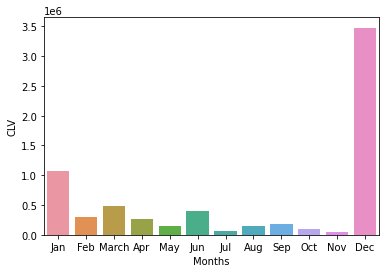

In [51]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.barplot(x = 'Months',
            y = 'CLV',
            data = monthly_clv)
 
# Show the plot
plt.show()